# Dog Breed Classification
The goal is to build a model capable of doing breed classification of a dog by just “looking” into its image. for this we will use the [Stanford Dog Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). It has around ~20 k images belonging to 120 classes and each image has an annotation associated with it.
We will have a try with a standard Machine learning approach without Neuronal network. The test will be run on 7 breeds. Note that No. of images per breed availiable for training data which is roughly ~300 images which seems quite small for the nature of this task. 

---

01. <a href="#1-Import-and-image-formating">Import and image formating</a>  
02. <a href="#2-Whitening">Whitening</a>  
03. <a href="#3-Semi-supervised-models">Descriptors</a>  
    3.1 <a href="#3.1-SIFT">SIFT</a>  
    3.2 <a href="#3.2-SURF">SURF</a>  
    3.3 <a href="#3.3-ORB">ORB</a> 
04. <a href="#4-Supervised-models">Baclustering</a>
05. <a href="#4-Supervised-models">Supervised models</a>  
06. <a href="#5-Conclusion"> Conclusion</a>



In [13]:
# general
import numpy as np
import matplotlib.pyplot as plt

# data 
import os
import cv2     # image operation, opencv-python==3.4.2.16 with opencv-contrib-python==3.4.2.16 for SIFT
import random  # schuffle dataset

# for bagging
from sklearn.cluster import KMeans
from sklearn import cluster, metrics
import pandas as pd


IMG_SIZE = 100  #  reshaped img size

## 1 Import and image formating

In [ ]:
def create_training_data(path, img_resize=None):
    """read all pictures from the Stanford Dog Dataset structure"""
    training_data = []
    filename_l = []
    for filename in os.listdir(path):
        path2 = os.path.join(path, filename)
        filename_l.append(filename)
        class_w = filename.split(sep="-")[1]
        for img in os.listdir(path2):
            img_array = cv2.imread(os.path.join(path2, img)) # , cv2.IMREAD_GRAYSCALE)
            training_data.append([img_array, class_w])
        
    return training_data

In [56]:
# importing
path = "./images/"
training_data = create_training_data(path)
print("{} pictures imported".format(len(training_data)))

# shuffle the data set
random.shuffle(training_data)

# separate images and labels
X = []
y = []
for feature, label in training_data:
    X.append(feature)
    y.append(label)
    
del training_data

1166 pictures imported


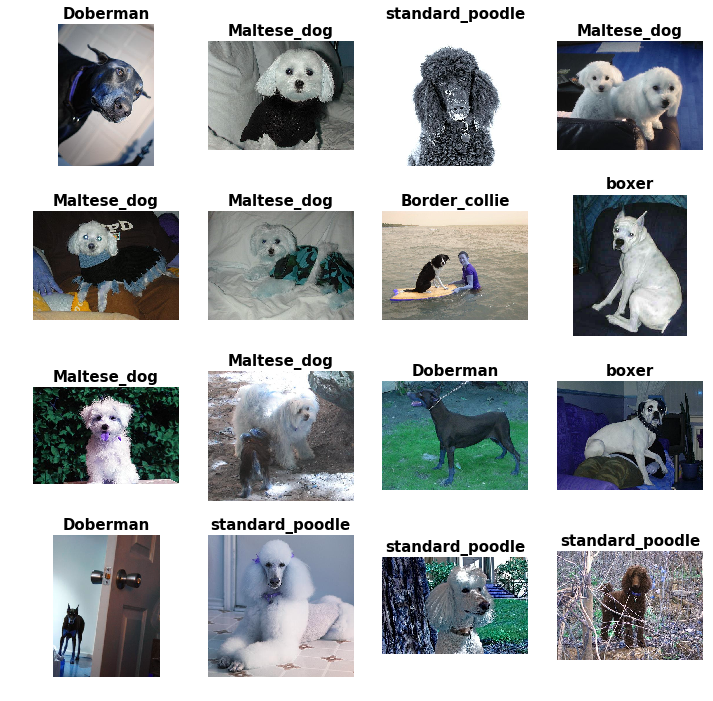

In [57]:
# example 16 pictures in a row

# idx of the first picture to plot
from_idx = 0

# plot
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,1+i)
    plt.title(y[i+from_idx], fontweight="bold", size=15)
    plt.imshow(X[i+from_idx])
    plt.axis('off')

plt.show;

There are colors pictures with different shapes.
We will first standardize them in term of size and colors (gray).

In [88]:
# transformations: resize, grayscale, blur

X_gray = []
for i in range(len(X)):
    X_gray.append(cv2.resize(X[i], (IMG_SIZE, IMG_SIZE)))          # new size
    X_gray[i] = cv2.cvtColor(X_gray[i], cv2.COLOR_BGR2GRAY)        # convert to grayscale
    X_gray[i] = cv2.GaussianBlur(X_gray[i], ksize=(5,5), sigmaX=1) # Blurs using a Gaussian filter
X_gray = np.array(X_gray).reshape(-1, IMG_SIZE, IMG_SIZE)     # list of arrays to a full array
# del X

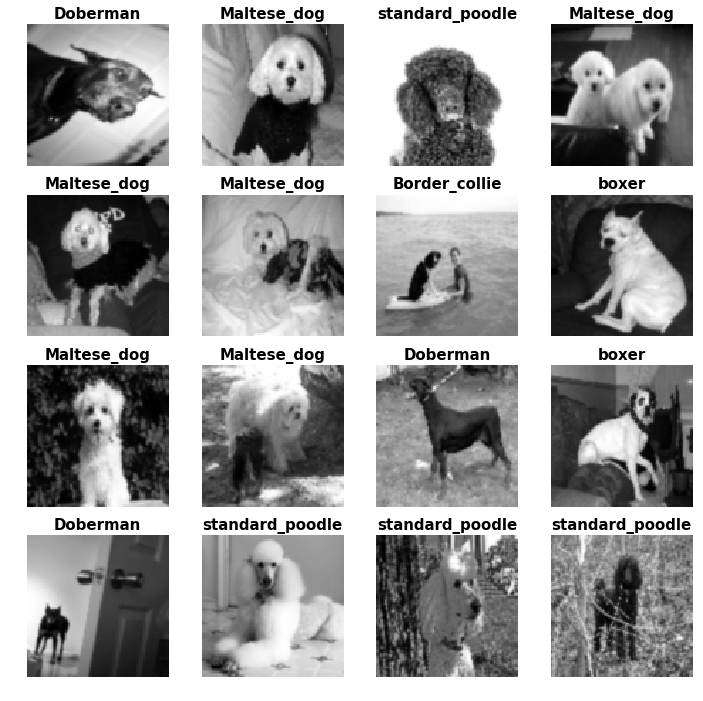

In [87]:
# example 16 pictures in a row

# idx of the first picture to plot
from_idx = 0

# plot
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,1+i)
    plt.title(y[i+from_idx], fontweight="bold", size=15)
    plt.imshow(X_gray[i+from_idx,:,:], cmap="gray")
    plt.axis('off')

plt.show;

In [93]:
# we are fine with that, let's save it to X
X = X_gray
del X_gray

In [94]:
# Save X and y to files
import pickle

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [1]:
# load
import pickle
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)

In [7]:
# reshape to a Nx100000 matrix
X2 = X2.reshape(-1, 10000)

# # zero-centre the data (this calculates the mean separately across
# # pixels and colour channels)
X3 = X2 - X2.mean(axis=0)

# # At this point, let's also do Global Contrast Normalization, which is quite often applied 
# # to image data. I'll use the L2 norm, which makes every image have vector magnitude 1:
X3 = X3 / np.sqrt((X3 ** 2).sum(axis=1))[:,None]

## 2 Whitening

In [14]:
# ZCA Whitening

# formating: reshape to a Nx10000 matrix
X = X.reshape(-1, IMG_SIZE*IMG_SIZE)

# compute the covariance of the image data
cov = np.cov(X, rowvar=True)     # cov is (N, N)

# singular value decomposition
U,S,V = np.linalg.svd(cov)        # U is (N, N), S is (N,)

# build the ZCA matrix
epsilon = 1e-5
zca_matrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))  # zca_matrix is (N,N)

# transform the image data         
X_zca = np.dot(zca_matrix, X)       # zca is (N, 3072)

In [15]:
# rescale ZCA results to 0-250 (for SIFT)
def rescale(x, bottom=0, maximum=255):
    """linear rescale of an array x"""
    
    # conversion to float needed: for strange reasons (x.min()-x.max()) overflow calc
    x_min = float(x.min())   
    x_max = float(x.max())
    
    b = (maximum*x_min-bottom*x_max)/(x_min-x_max)
    a = (maximum-b)/x_max  
    return a*x+b

# reformat for SIFT: 
# rescale intensity to 0 - 255
X_zca = np.apply_along_axis(rescale, 1, X_zca)

# transform to int 8 bit
X_zca = X_zca.astype(np.uint8)

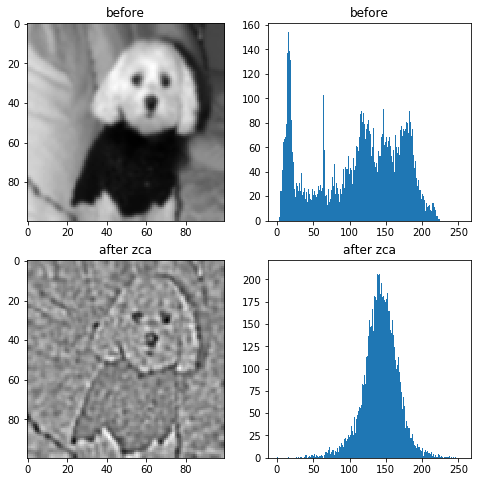

In [16]:
idx = 1
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.title("before")
plt.imshow(X[idx].reshape((IMG_SIZE,IMG_SIZE)), cmap="gray")

plt.subplot(2,2,2)
plt.title("before")
n, bins, patches = plt.hist(X[idx], bins=range(255), cumulative=False)

plt.subplot(2,2,3)
plt.title("after zca")
plt.imshow(X_zca[idx].reshape((IMG_SIZE,IMG_SIZE)), cmap="gray")

plt.subplot(2,2,4)
plt.title("after zca")
n, bins, patches = plt.hist(X_zca[idx], bins=range(255), cumulative=False)

plt.show;

## 3 Descriptors

In [81]:
# some functions to compute and plot descriptors

def compute_descriptors(X, method):
    """compute descriptors on each image of X. It returns 2 lists and one dictionary.
    
    Inputs:
        X: 2D Array of images  (N images x M pixels)
        method: algorithm use to creat descriptors could be "sift", "surf", orb
    
    Outputs:
        keypoints: list of all keypoints
        descriptors: list of all descripot
        img_descriptor_idx: dict of indexes. map img (X.index()) with keypoints/descriptors
            key=image index (from X)
            value=list of indexes (from keypoints, descriptors)
    """

    methods = {"sift": cv2.xfeatures2d_SIFT.create(),
               "surf": cv2.xfeatures2d_SURF.create(),
               "orb": cv2.ORB_create(patchSize=10, edgeThreshold=10, nfeatures=50)
              } 
    descriptor_size = {"sift": 128, "surf": 64, "orb": 32} 

    # initialisation
    # apply to the fist image
    algo = methods[method]
    keypoints, descriptors = algo.detectAndCompute(X[0,:].reshape((IMG_SIZE, IMG_SIZE)), None)
    
    n = 0
    img_descriptor_idx = {}
    keypoints_all = []  #list of keypoints of each pictures
    descriptors_all = np.empty((0,descriptor_size[method]))
    for idx in range(len(X)):
        img = X[idx].reshape((IMG_SIZE,IMG_SIZE))
        keypoints, descriptors = algo.detectAndCompute(img, None)

        descriptors_all = np.concatenate((descriptors_all, descriptors))
        keypoints_all.append(keypoints)
        img_descriptor_idx[idx] = list(range(n, n+len(descriptors)))
        n = n + len(descriptors) 
    
    return keypoints_all, descriptors_all, img_descriptor_idx


def plot_descriptors(data, method, img_descriptor_idx, keypoints_all, 
                    descriptors_all, img_idx=0, title="Descriptors"):
    """plot results for different descriptor from cv2"""
    
    shapes = {"sift": (16,8),
             "surf": (8,8),
             "orb": (8,4)}
    descriptor_shape = shapes[method]
    gray = X[img_idx,:].reshape((IMG_SIZE,IMG_SIZE))
    idx_selection = img_descriptor_idx[img_idx]
    
    # plots
    plt.figure(figsize=(12,5))
    plt.suptitle(title,fontsize=20)
    plt.subplot(1,3,1)
    img = cv2.drawKeypoints(image=gray,
                            keypoints=keypoints_all[img_idx],
                            outImage=np.array([]),
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img, cmap="gray")

    plt.subplot(1,3,2)
    plt.title("Fist descriptor")
    plt.imshow(descriptors_all[idx_selection[0]].reshape(descriptor_shape))   
    plt.xlabel("Directions")
    plt.ylabel("Sub-aera")

    plt.subplot(1,3,3)
    plt.title("Second descriptor")
    plt.imshow(descriptors_all[idx_selection[1]].reshape(descriptor_shape))   
    plt.xlabel("Directions")
    plt.ylabel("Sub-aera")
    plt.show;

In [88]:
# for patern reasons, SIFT and SURF have been removed on last versions of opencv (~ 2018)
# we will previous versions: opencv-python==3.4.2.16 and opencv-contrib-python==3.4.2.16
cv2.__version__

'3.4.2'

### 3.1 SIFT
Blabla what is it !?

In [78]:
sift_keypoints_all, sift_descriptors_all, sift_img_descriptor_idx = compute_descriptors(X, "sift")

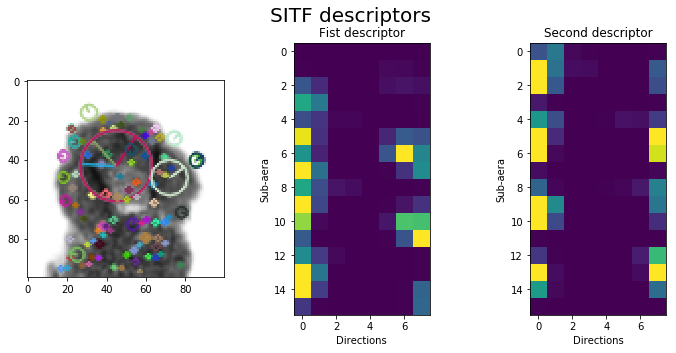

In [79]:
plot_descriptors(data=X, 
                method="sift", 
                img_descriptor_idx=sift_img_descriptor_idx, 
                keypoints_all=sift_keypoints_all, 
                descriptors_all=sift_descriptors_all, 
                img_idx=2, 
                title="SITF descriptors")

In [86]:
# descriptor plot
def plot_descriptor_rose(descriptors, idx):
    
    desc = descriptors[idx].reshape(16, 8)
    
    fig = plt.figure(figsize=(16,16))
    fig.suptitle("SIFT descriptor number {}".format(idx), fontweight="bold", size=20)
    for i in range(16):

        N = 8
        bottom = 0

        theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
        radii = desc[i]
        width = (2*np.pi) / N

        ax = plt.subplot(4, 4, i+1, polar=True)
        bars = ax.bar(theta, radii, width=width, bottom=bottom,  color = "g")
        plt.ylim(0, desc.max() )
    plt.show()

In [87]:
plot_descriptor_rose(descriptors,5)

ValueError: cannot reshape array of size 32 into shape (16,8)

## SURF

In [82]:
surf_keypoints_all, surf_descriptors_all, surf_img_descriptor_idx = compute_descriptors(X, "surf")

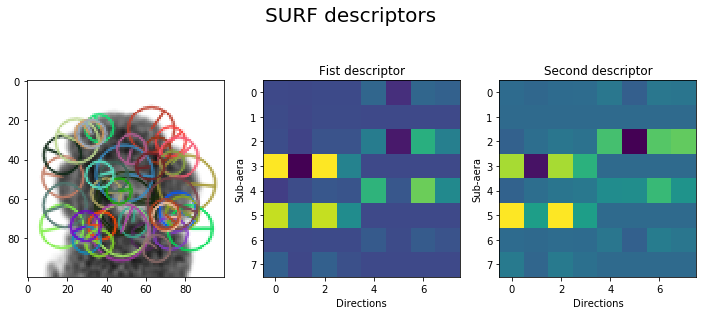

In [83]:
plot_descriptors(data=X, 
                method="surf", 
                img_descriptor_idx=surf_img_descriptor_idx, 
                keypoints_all=surf_keypoints_all, 
                descriptors_all=surf_descriptors_all, 
                img_idx=2, 
                title="SURF descriptors")

## ORB

In [84]:
orb_keypoints_all, orb_descriptors_all, orb_img_descriptor_idx = compute_descriptors(X, "orb")

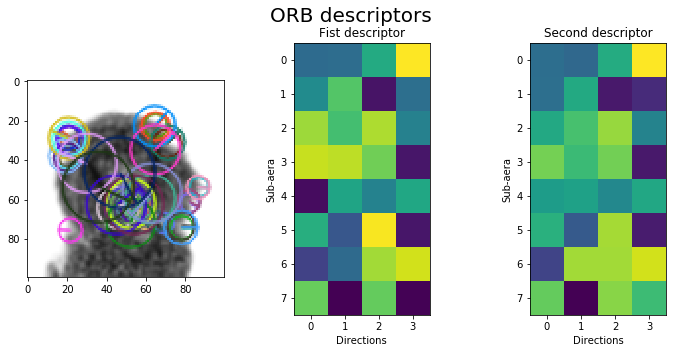

In [85]:
plot_descriptors(data=X, 
                method="orb", 
                img_descriptor_idx=orb_img_descriptor_idx, 
                keypoints_all=orb_keypoints_all, 
                descriptors_all=orb_descriptors_all, 
                img_idx=2, 
                title="ORB descriptors")

desciptor shape:  (57, 128)
desciptor shape:  (109, 128)


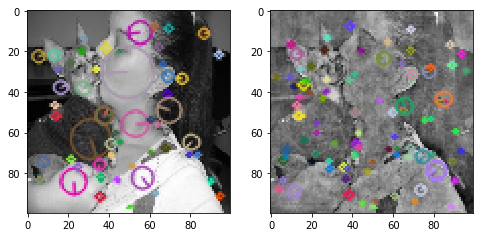

In [244]:
# SIFT comparaison with raw input (X2) and ZCA
idx = 3
inputs = [X2, zca]

sift = cv2.xfeatures2d_SIFT.create()

plt.figure(figsize=(8,12))
for i in [0,1]:
    
    resc = rescale(inputs[i][idx], 0, 255)
    resc = resc.astype(np.uint8)
    gray = resc.reshape((100, 100))

    keypoints, descriptors = sift.detectAndCompute(gray, None)

    img = cv2.drawKeypoints(gray,
                            keypoints,
                            outImage=np.array([]),
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.subplot(1, 2, i+1)
    print("desciptor shape: ", descriptors.shape)
    plt.imshow(img, cmap="gray")
plt.show;

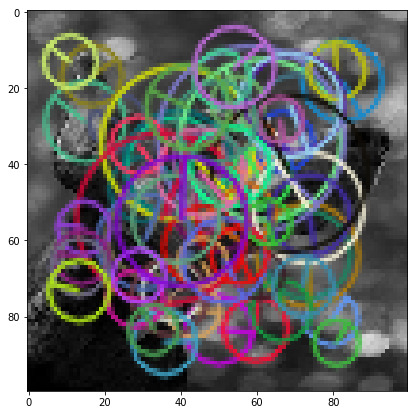

In [93]:
# SURF


# img = cv2.imread('n02085620_326.jpg')
# gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

img =X2[12].reshape((100,100))
gray = img


# img = cv2.imread("the_book_thief.jpg", cv2.IMREAD_GRAYSCALE)
 
# sift = cv2.xfeatures2d.SIFT_create()
# surf = cv2.xfeatures2d.SURF_create()
 
sift = cv2.xfeatures2d_SURF.create()
 
keypoints, descriptors = sift.detectAndCompute(gray, None)
kp = sift.detect(gray,None)
 
img = cv2.drawKeypoints(gray,
                        kp,
                        outImage=np.array([]),
                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
    
plt.figure(figsize=(7,7))
plt.imshow(img, cmap="gray")
# cv2.imshow("Image", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

## Bag of words - clustering

In [ ]:
# to start with, as a rule of thumb we will use a number of cluster equal to 10 time 
# the number of classes
n_cluster = len(set(y))*10

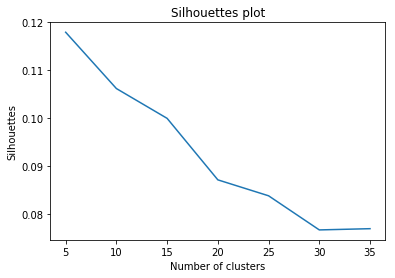

In [92]:
# surf descriptors
from sklearn.cluster import KMeans
from sklearn import cluster, metrics
import pandas as pd

kmeans = KMeans()

# inputs
X_features = surf_descriptors_all

# Test of the number of clustering
min_cluster = 5
max_cluster = 36

silhouettes = []
n_per_groups = []
kmean_centers = []
for num_clusters in range(min_cluster, max_cluster, 5):
    kmeans = KMeans(n_clusters=num_clusters, random_state=111)
    kmeans.fit(X_features)
    silh = metrics.silhouette_score(X_features, kmeans.labels_)
    silhouettes.append(silh)

    # save relvent variable for each runs (centers, number
    # of occurence per clusters)
    kmean_centers.append(kmeans.cluster_centers_)
    # save group repartition
    n_per_groups.append(pd.value_counts(kmeans.labels_))

    # add group for each customer in the main df
#     new_col_name = str(num_clusters) + "_cluster"
#     cust_df[new_col_name] = kmeans.labels_

# Silhouette plot

# inputs
x = list(range(min_cluster, max_cluster, 5))
y = silhouettes

# plot
plt.plot(x, y)
plt.title("Silhouettes plot")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouettes")
plt.show()

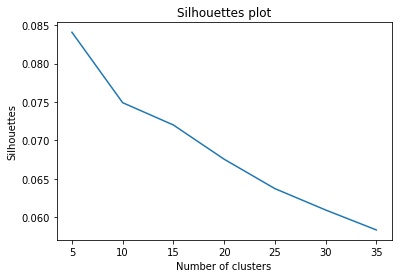

In [65]:
# orb descriptors
kmeans = KMeans()

# inputs
X_features = orb_descriptors_all

# Test of the number of clustering
min_cluster = 5
max_cluster = 36

silhouettes = []
n_per_groups = []
kmean_centers = []
for num_clusters in range(min_cluster, max_cluster, 5):
    kmeans = KMeans(n_clusters=num_clusters, random_state=111)
    kmeans.fit(X_features)
    silh = metrics.silhouette_score(X_features, kmeans.labels_)
    silhouettes.append(silh)

    # save relvent variable for each runs (centers, number
    # of occurence per clusters)
    kmean_centers.append(kmeans.cluster_centers_)
    # save group repartition
    n_per_groups.append(pd.value_counts(kmeans.labels_))

    # add group for each customer in the main df
#     new_col_name = str(num_clusters) + "_cluster"
#     cust_df[new_col_name] = kmeans.labels_

# Silhouette plot

# inputs
x = list(range(min_cluster, max_cluster, 5))
s = silhouettes

# plot
plt.plot(x, s)
plt.title("Silhouettes plot")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouettes")
plt.show()

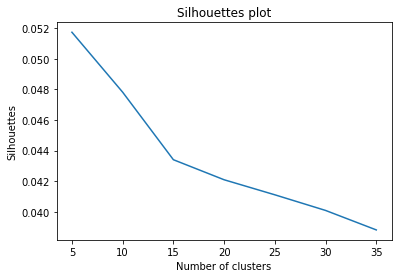

In [66]:
# sift descriptors
kmeans = KMeans()

# inputs
X_features = sift_descriptors_all

# Test of the number of clustering
min_cluster = 5
max_cluster = 36

silhouettes = []
n_per_groups = []
kmean_centers = []
for num_clusters in range(min_cluster, max_cluster, 5):
    kmeans = KMeans(n_clusters=num_clusters, random_state=111)
    kmeans.fit(X_features)
    silh = metrics.silhouette_score(X_features, kmeans.labels_)
    silhouettes.append(silh)

    # save relvent variable for each runs (centers, number
    # of occurence per clusters)
    kmean_centers.append(kmeans.cluster_centers_)
    # save group repartition
    n_per_groups.append(pd.value_counts(kmeans.labels_))

    # add group for each customer in the main df
#     new_col_name = str(num_clusters) + "_cluster"
#     cust_df[new_col_name] = kmeans.labels_

# Silhouette plot

# inputs
x = list(range(min_cluster, max_cluster, 5))
y = silhouettes

# plot
plt.plot(x, y)
plt.title("Silhouettes plot")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouettes")
plt.show()

In [99]:
# inputs
X_features = surf_descriptors_all
kmeans = KMeans(n_clusters=70, random_state=111)
kmeans.fit(X_features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=70, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

In [98]:
metrics.silhouette_score(X_features, kmeans.labels_)

0.04270185705731596

In [100]:
# format: group descriptors to features
def format_img_features(img_descriptor_idx, labels_):
    # reformat the dic to an term frequency table
    image_N = []
    for key, values in img_descriptor_idx.items():
        for val in values:
            image_N.append(key)

    img_feat = pd.DataFrame({"images": image_N, "features": labels_})
    pivot_count = pd.crosstab(index=img_feat["images"], columns=img_feat["features"])
    
    # rename features columns
    names_ = []
    for e in  pivot_count.columns:
        names_.append("feat_{}".format(e))
    pivot_count.columns = names_
    
    return pivot_count

In [101]:
# term frequency table 
tf = format_img_features(surf_img_descriptor_idx, kmeans.labels_)
tf.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69
images,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,0,1,0,1,0,1,0,...,2,0,0,0,0,0,0,1,0,1
1,0,1,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,2,0,1,0,0,0,...,0,0,0,2,0,0,1,0,0,1
3,0,2,1,0,2,0,3,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,4,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [102]:
tf.sum()

feat_0      678
feat_1      784
feat_2      963
feat_3      202
feat_4      736
feat_5      380
feat_6      983
feat_7      758
feat_8      562
feat_9      432
feat_10     674
feat_11     874
feat_12     739
feat_13     566
feat_14     722
feat_15     610
feat_16     936
feat_17    1297
feat_18     563
feat_19     639
feat_20     727
feat_21     581
feat_22     685
feat_23     573
feat_24    1305
feat_25     479
feat_26     921
feat_27     896
feat_28     799
feat_29     724
           ... 
feat_40     706
feat_41     644
feat_42     845
feat_43     550
feat_44     968
feat_45     592
feat_46     572
feat_47     619
feat_48     535
feat_49     799
feat_50     394
feat_51     557
feat_52     655
feat_53     424
feat_54     677
feat_55     554
feat_56     511
feat_57     523
feat_58     630
feat_59     574
feat_60     676
feat_61     660
feat_62     666
feat_63     988
feat_64     692
feat_65     579
feat_66     516
feat_67     711
feat_68     451
feat_69     514
Length: 70, dtype: int64

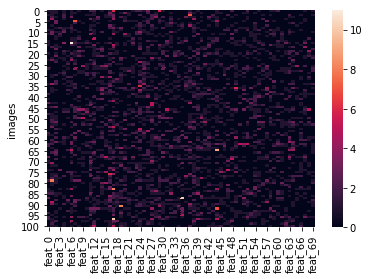

In [103]:
import seaborn as sns
sns.heatmap(tf.loc[0:100,:])

Text(0.5,0,'Features')

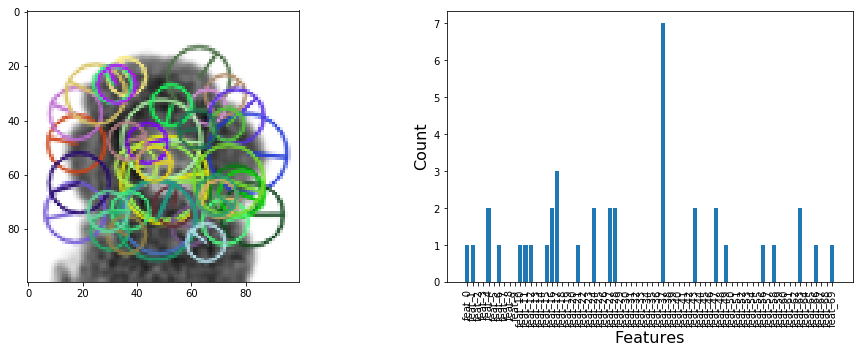

In [105]:
idx=2

#inputs
gray = X[idx,:].reshape((IMG_SIZE,IMG_SIZE))
idx_selection = surf_img_descriptor_idx[idx]  # selection of descriptor's idx for this image

# plots
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
img = cv2.drawKeypoints(image=gray,
                        keypoints=surf_keypoints_all[idx],
                        outImage=np.array([]),
                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img, cmap="gray")

plt.subplot(1,2,2)
plt.bar(x=tf.columns, height=tf.loc[idx,:])
plt.xticks(rotation=90)
plt.ylabel("Count", size=16)
plt.xlabel("Features", size=16)

In [111]:
y

['Doberman',
 'Maltese_dog',
 'standard_poodle',
 'Maltese_dog',
 'Maltese_dog',
 'Maltese_dog',
 'Border_collie',
 'boxer',
 'Maltese_dog',
 'Maltese_dog',
 'Doberman',
 'boxer',
 'Doberman',
 'standard_poodle',
 'standard_poodle',
 'standard_poodle',
 'boxer',
 'Border_collie',
 'Maltese_dog',
 'Maltese_dog',
 'Maltese_dog',
 'Chihuahua',
 'standard_poodle',
 'boxer',
 'Doberman',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'boxer',
 'Chihuahua',
 'Border_collie',
 'Maltese_dog',
 'boxer',
 'German_shepherd',
 'German_shepherd',
 'Maltese_dog',
 'standard_poodle',
 'Maltese_dog',
 'Maltese_dog',
 'boxer',
 'Border_collie',
 'German_shepherd',
 'Maltese_dog',
 'Border_collie',
 'Chihuahua',
 'German_shepherd',
 'Border_collie',
 'Doberman',
 'Maltese_dog',
 'Chihuahua',
 'Doberman',
 'Doberman',
 'Doberman',
 'Doberman',
 'Maltese_dog',
 'Doberman',
 'German_shepherd',
 'standard_poodle',
 'boxer',
 'Maltese_dog',
 'boxer',
 'Doberman',
 'German_shepherd',
 'Chihuahua',
 'Doberman',
 '

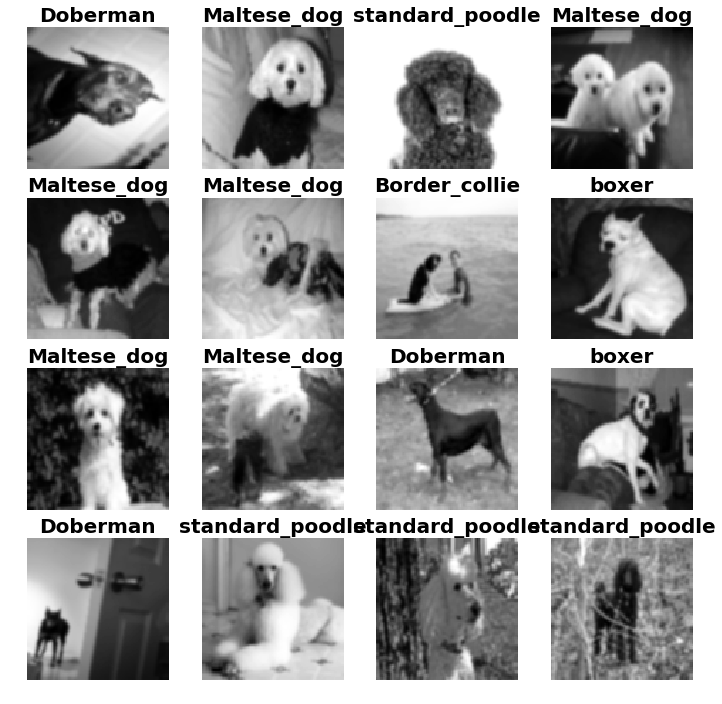

In [112]:
plt.figure(figsize=(12,12))

for i in range(16):
    plt.subplot(4,4,1+i)
    plt.title(y[i], fontweight="bold", size=20)
    plt.imshow(X[i].reshape((IMG_SIZE,IMG_SIZE)), cmap="gray")
    plt.axis('off')

plt.show;

In [113]:
y_df = pd.DataFrame({"y":y})
y_df.head()

,y
0,Doberman
1,Maltese_dog
2,standard_poodle
3,Maltese_dog
4,Maltese_dog


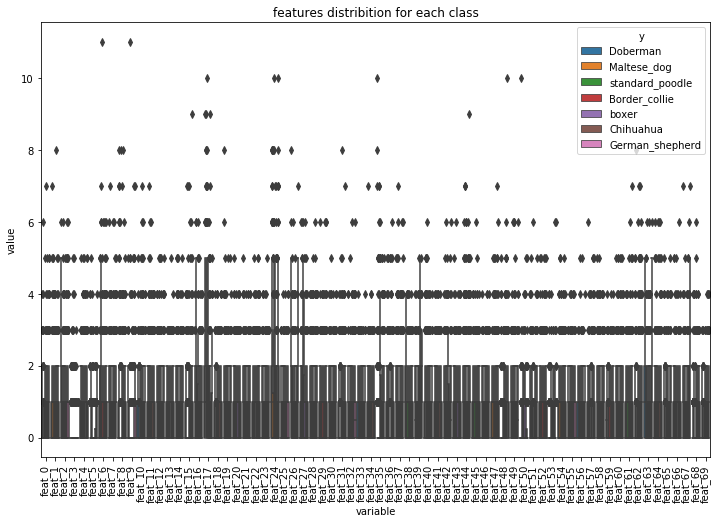

In [115]:
# feature distribution per class

# inputs formating
y_df = pd.DataFrame({"y":y})
Xy = pd.concat([tf,y_df], axis=1)

# plot
plt.figure(figsize=(12, 8))
plt.title("features distribition for each class")
sns.boxplot(x="variable", y="value", data=Xy.melt(id_vars="y"), hue="y")
plt.xticks(rotation=90)

del y_df, Xy

No real difference in term of distribution on two classes...

## PCA

C:\Users\ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  import sys


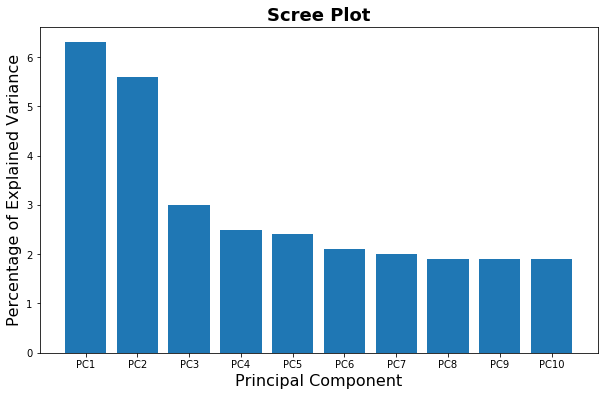

In [116]:
# Perform PCA
from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np

# scale inputs
X_scal = preprocessing.scale(tf)
# X_scal = pd.DataFrame(X_scal, columns=features_selection)

# model
pca = PCA()  # create a PCA object
pca.fit(X_scal)  # do the math

# get PCA coordinates for scaled_data (return nparray)
pca_data = pca.transform(X_scal)

# Draw a scree plot and a PCA plot
per_var = np.round(pca.explained_variance_ratio_[:10] * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

plt.figure(figsize=(10, 6))
plt.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance', size=16)
plt.xlabel('Principal Component', size=16)
plt.title("Scree Plot", size=18, fontweight="bold")
plt.show()

In [122]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70
0,-2.025948,0.072765,-1.188803,1.577977,-0.504698,-0.684238,-0.698776,0.010087,0.027379,-1.701946,...,-1.187678,-0.049018,1.056923,0.109266,0.430614,-1.618360,0.897916,1.093012,0.701204,0.263664
1,-2.486757,-0.606142,-0.684872,-0.095800,-0.599932,0.591082,0.036874,-0.886186,-0.553865,0.467993,...,0.090624,-0.401307,0.205649,0.497998,-1.159852,-0.464672,0.775639,-0.129384,-0.017978,-0.414525
2,-2.597908,2.143098,-1.266888,0.235785,0.468344,3.536986,-1.921650,0.738694,-0.550284,0.722137,...,-2.269443,0.091747,0.482097,-0.606181,-0.000388,-0.001480,0.456625,-0.226367,-0.491655,0.021743
3,-0.406538,0.735632,0.280456,-0.230785,-1.346477,0.675237,-0.583479,-0.237408,0.259503,0.926589,...,0.281522,-0.851175,0.582203,0.700571,-2.241983,-0.800121,1.821368,-0.496142,0.419257,-1.334018
4,-2.096369,0.596166,-0.917252,0.726749,0.417496,-0.487986,0.631604,-1.491516,3.180363,1.873365,...,-0.524397,0.106914,0.632368,0.378945,-0.564528,-1.423036,0.984119,0.180068,0.273855,0.038842


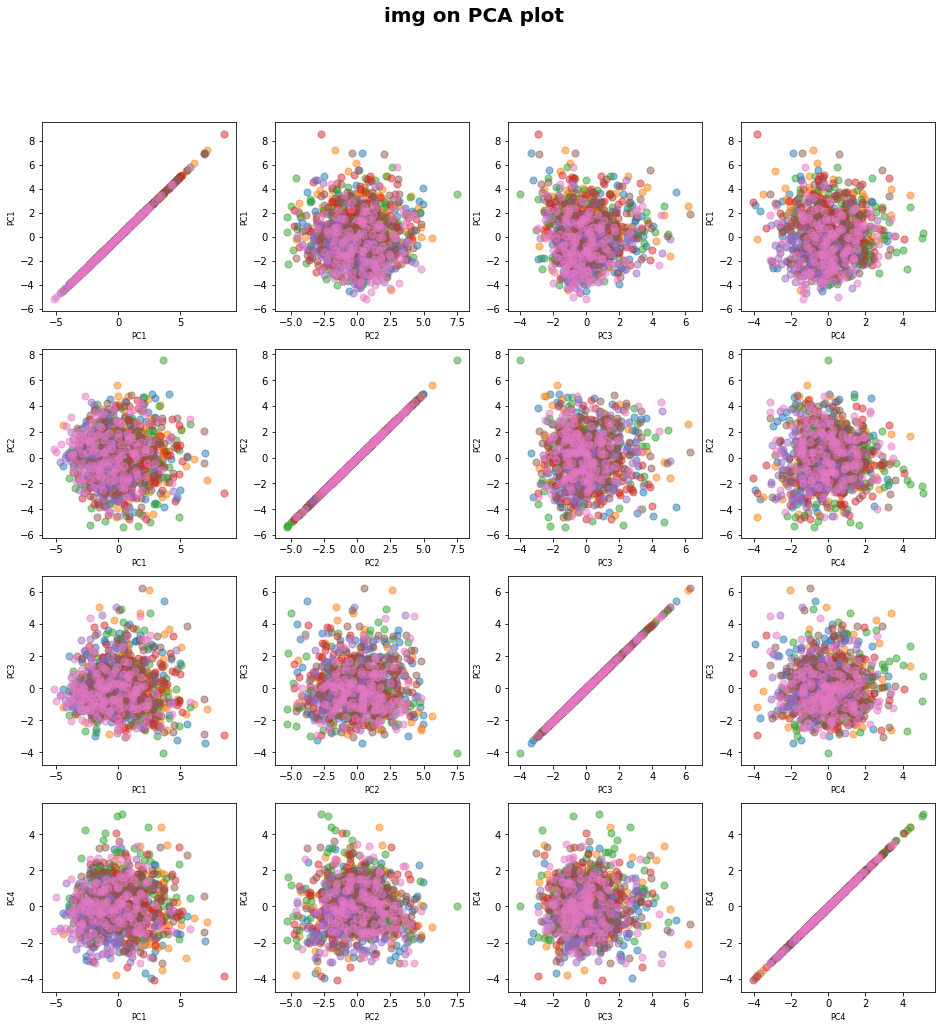

In [184]:
# PCX plot

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

# inputs plot1
pca_df = pd.DataFrame(pca_data, columns=labels) # , index=data["movie_title"], columns=labels)
PCA_C = ["PC1", "PC2", "PC3", "PC4"]

# plot
plt.figure(figsize=(16, 16))
plt.suptitle("img on PCA plot", fontweight="bold", size=20)
i=1
for composent_x in PCA_C:
    for composent_y in PCA_C:
        plt.subplot(4,4,i)
        for g in np.unique(y):
            ix = [i for i, val in enumerate(y) if val == g]   # :)
            plt.scatter(pca_df.loc[ix,composent_y], 
                        pca_df.loc[ix,composent_x], 
                        label = g, 
                        s = 50, 
                        alpha = 0.5)
            plt.ylabel(composent_x, size=8)
            plt.xlabel(composent_y, size=8)
#             plt.legend()
            plt.xlim([-6, 6])
            plt.ylim([-6, 6])
        i = i+1
plt.show()

## t-SNE

In [182]:
## t-SNE
from sklearn import manifold
from sklearn import preprocessing

tsne = manifold.TSNE(n_components=2, perplexity=60, n_iter=3000, init='pca')
X_tsne = tsne.fit_transform(X_scal)

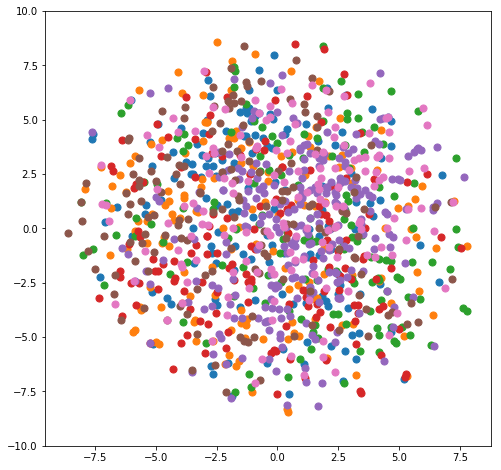

In [188]:
# vizualisation
plt.figure(figsize=(8, 8))

for g in np.unique(y):
    ix = [i for i, val in enumerate(y) if val == g]
    plt.scatter(X_tsne[ix,0], X_tsne[ix,1], s=50)
    plt.ylim([-10,10])
plt.show()

## Model

In [198]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tf, y, random_state=0,
                                                    stratify=y,
                                                    train_size=0.8)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [199]:
X_train.shape

(932, 70)

In [ ]:
# models
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler  # 0.45
from sklearn import metrics

# model lib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from time import time
t0 = time()

# Gaussian Naive Bayes
param_grid = {'var_smoothing': [1e-10, 1e-09, 1e-08, 1e-07],}
gauss_grid = GridSearchCV(GaussianNB(), param_grid, cv=6, scoring="f1_macro")
gauss_grid.fit(X_train, y_train)
y_pred_gauss = gauss_grid.predict(X_test)
print("Gaussian Naive Bayes done in: ", round((time() - t0)/60,0), " min")
t0 = time()
# K Neighbors Classifier with scalled input
scale_knn = Pipeline(steps=[('scaller', StandardScaler()),
                            ('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors': np.arange(2, 16, 2),}
scale_knn_grid = GridSearchCV(scale_knn, param_grid, cv=6, scoring="f1_macro")
scale_knn_grid.fit(X_train, y_train)
y_pred_scale_knn = scale_knn_grid.predict(X_test)
print("K Neighbors done in: ", round((time() - t0)/60,0), " min")
t0 = time()

# Random Forest
param_grid = {'max_depth': [10, 20, None],}
rf_grid = GridSearchCV(RandomForestClassifier(n_estimators=100,
                                           random_state=0),
                    param_grid, cv=6,
                    scoring="f1_macro")
rf_grid.fit(X_train, y_train)
y_pred_rf = rf_grid.predict(X_test)
print("Random Forest done in: ", round((time() - t0)/60,0), " min")
t0 = time()

# Support Vector Machine
param_grid = {"gamma": ["auto", "scale"]}
svm_grid = GridSearchCV(SVC(), param_grid, cv=6, scoring="f1_macro")
svm_grid.fit(X_train, y_train)
y_pred_svm = svm_grid.predict(X_test)
print("Support Vector Machine done in: ", round((time() - t0)/60,0), " min")

Gaussian Naive Bayes done in:  0.0  min


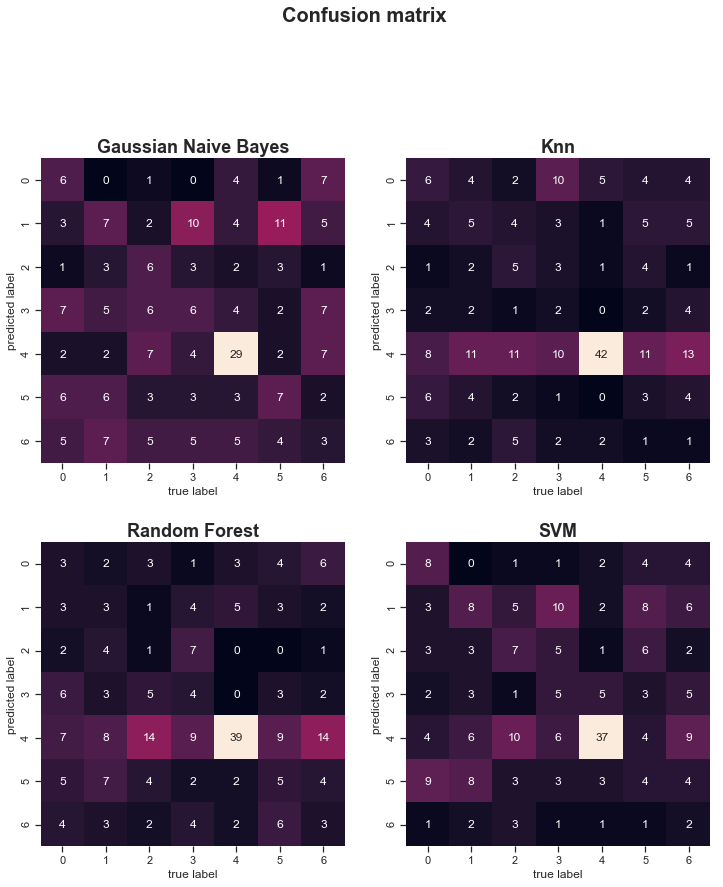

In [201]:
# confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# inputs
model_name  = ["Gaussian Naive Bayes", "Knn", "Random Forest", "SVM"]
y_pred_models = [y_pred_gauss, y_pred_scale_knn, y_pred_rf, y_pred_svm]

# plot
sns.set(style="ticks", palette="pastel")
fig = plt.figure(figsize=(12,20))
fig.suptitle("Confusion matrix", fontweight="bold", size=20)
for i,y_pred in enumerate(y_pred_models):
    plt.subplot(3,2,i+1) 
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.title(model_name[i], fontweight="bold",size = 18)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

In [202]:
# metrics comparaison
for i,y_pred in enumerate(y_pred_models):
    print(model_name[i])
    print(metrics.classification_report(y_pred, y_test))
    print("---------------------------------------------------------\n")

Gaussian Naive Bayes
                 precision    recall  f1-score   support

  Border_collie       0.20      0.32      0.24        19
      Chihuahua       0.23      0.17      0.19        42
       Doberman       0.20      0.32      0.24        19
German_shepherd       0.19      0.16      0.18        37
    Maltese_dog       0.57      0.55      0.56        53
          boxer       0.23      0.23      0.23        30
standard_poodle       0.09      0.09      0.09        34

      micro avg       0.27      0.27      0.27       234
      macro avg       0.25      0.26      0.25       234
   weighted avg       0.28      0.27      0.27       234

---------------------------------------------------------

Knn
                 precision    recall  f1-score   support

  Border_collie       0.20      0.17      0.18        35
      Chihuahua       0.17      0.19      0.18        27
       Doberman       0.17      0.29      0.21        17
German_shepherd       0.06      0.15      0.09        13


## TEST AREA

In [213]:
from sklearn.metrics import f1_score

f1_score(y_pred_svm, y_test, average="weighted")

0.32600542318470405

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline   
plt.rcParams['image.cmap'] = 'gray'

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [225]:
y = np.array(y)

In [207]:
train_idx = X_train.index
test_idx = X_test.index

X_gray = X.copy()

In [229]:
 # optimisation on inputs and descriptor algorithm
import warnings          # to clean notebook from minor warnings
warnings.filterwarnings('ignore')

## grid results array
grid_score_rf = pd.DataFrame(0, 
                          index=[0, 1], 
                          columns=["sift", "surf", "orb"]) 
grid_score_rf.index.name = "inputs"
grid_score_rf.columns.name = "algo"
grid_score_svm = grid_score_rf.copy()

for i, X in enumerate([X_gray, X_zca]):
    for algo in ["orb", "surf", "sift"]:

        # descriptors
        keypoints_all, descriptors_all, img_descriptor_idx = compute_descriptors(X, algo)

        # clustering
        X_features = descriptors_all
        kmeans = KMeans(n_clusters=70, random_state=111)
        kmeans.fit(X_features)

        # term frequency
        tf = format_img_features(img_descriptor_idx, kmeans.labels_)

        # split data
        X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]

        # Models -----------------------------------------------------------------------
        # Random Forest
        param_grid = {'max_depth': [10, 20, None]}
        rf_grid = GridSearchCV(RandomForestClassifier(n_estimators=100,
                                                   random_state=0),
                            param_grid, cv=6,
                            scoring="f1_macro")
        rf_grid.fit(X_train, y_train)
        y_pred_rf = rf_grid.predict(X_test)
        print("Random Forest done in: ", round((time() - t0)/60,0), " min")
        t0 = time()

        # Support Vector Machine
        param_grid = {"gamma": ["auto", "scale"]}  # gamma 0.01, 0.001, 0.0001
        svm_grid = GridSearchCV(SVC(), param_grid, cv=6, scoring="f1_macro")
        svm_grid.fit(X_train, y_train)
        y_pred_svm = svm_grid.predict(X_test)
        print("Support Vector Machine done in: ", round((time() - t0)/60,0), " min")
        
grid_score_rf.loc[i, algo] = f1_score(y_pred_rf, y_test, average="weighted")
grid_score_svm.loc[i, algo] = f1_score(y_pred_svm, y_test, average="weighted") 

Random Forest done in:  24.0  min
Support Vector Machine done in:  3.0  min
Random Forest done in:  6.0  min
Support Vector Machine done in:  4.0  min
Random Forest done in:  10.0  min
Support Vector Machine done in:  3.0  min
Random Forest done in:  6.0  min
Support Vector Machine done in:  3.0  min
Random Forest done in:  8.0  min
Support Vector Machine done in:  3.0  min
Random Forest done in:  34.0  min
Support Vector Machine done in:  3.0  min


In [224]:
np.array(y)

array(['Doberman', 'Maltese_dog', 'standard_poodle', ..., 'Border_collie',
       'Border_collie', 'Border_collie'], dtype='<U15')

In [230]:
grid_score_rf

algo,sift,surf,orb
inputs,,,
0,0.000000,0,0
1,0.325529,0,0


In [232]:
grid_score_svm

algo,sift,surf,orb
inputs,,,
0,0.000000,0,0
1,0.357895,0,0
